This notebook contains analysis where we use the paradigm of analysing character timed sequences.

In [1]:
cd ..

/home/neil/cloud/haberrspd


In [2]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline
from haberrspd.__init__ import *
from haberrspd.__init_paths import data_root # Where the data lives
# from haberrspd.preprocess import create_long_form_NLP_datasets_from_MJFF_English_data

---

## Things I would like to try with flair [for characters]:

1. Combine English (MJFF and mechanical turk data) and Spanish embeddings
2. Do flair-embeddings + CNN like [this](https://github.com/huggingface/pytorch-pretrained-BERT/issues/129) (compare against ELMo and BERT)
3. Extend to MJFF English + MJFF Spanish + NeuroQwerty
4. Model optimisation (BO and various other options)
5. [Learning curves -- do them](https://www.deeplearning.ai/content/uploads/2018/09/Ng-MLY01-12.pdf)

Issues to think of:

- Upper and lower case
- Currently flair does not have CNN support, by the looks of things

In [3]:
from haberrspd.pdnet_flair import (pdnet_char_mjff, 
                                    Config, 
                                    DATA_ROOT_FASTTEXT, 
                                    make_train_test_dev,
                                    make_data_flair_readable)
import os
from pathlib import Path
from flair.training_utils import EvaluationMetric
import torch
from collections import Counter
from flair.data import Sentence
from flair.models import TextClassifier

In [4]:
language='english'
lang_dir = Path('char_' + str(language) + "/")

## DATA prep and checks

In [16]:
# long format
df = pd.read_csv('data/MJFF/preprocessed_long_format_EnglishData.csv', 
                usecols=['Patient_ID', 'Diagnosis', 'Sentence_ID','Preprocessed_typed_sentence'])

In [6]:
# normal 
df = pd.read_csv('data/MJFF/preprocessed_EnglishData.csv', 
                usecols=['Patient_ID', 'Diagnosis', 'Sentence_ID','Preprocessed_typed_sentence'])

In [17]:
# Options

upper_and_lower_case = False

# Checks

if not upper_and_lower_case:
    assert 'Preprocessed_typed_sentence' in df.columns
    # Recast dataset all in lowercase
    df.Preprocessed_typed_sentence = df.Preprocessed_typed_sentence.str.lower()

# Ensure that the format is flair-readable
data = make_data_flair_readable(df)
assert "__label__0" and "__label__1" in set(data.label)
    
# if not all([os.path.exists(DATA_ROOT_FASTTEXT / lang_dir / my_file)
#             for my_file in ['test.csv', 'dev.csv', 'train.csv']]):
make_train_test_dev(data, DATA_ROOT_FASTTEXT / lang_dir)

In [8]:
Counter(data.label)

Counter({'__label__0': 741, '__label__1': 435})

In [18]:
# Config parameters for the model training
config = Config(
    
    # RNN model specification
    hidden_size=8,
    reproject_words=True,
    bidirectional=True,
    rnn_type="GRU", # LSTM does not work for some reason
    rnn_layers=1,
    reproject_words_dimension=None,
    dropout=0.5,
    
    # Training
    evaluation_metric=EvaluationMetric.MICRO_F1_SCORE,
    learning_rate=0.001,
    anneal_factor=0.5,
    mini_batch_size=64,
    patience=3,
    max_epochs=10
)

### Run...

In [19]:
assert torch.cuda.is_available(), "Do not run this model with GPU support."
# Run model
pdnet_char_mjff(config)

2019-06-05 10:15:45,008 Reading data from data/MJFF/fasttext/char_english
2019-06-05 10:15:45,008 Train: data/MJFF/fasttext/char_english/train.csv
2019-06-05 10:15:45,009 Dev: data/MJFF/fasttext/char_english/dev.csv
2019-06-05 10:15:45,010 Test: data/MJFF/fasttext/char_english/test.csv
2019-06-05 10:15:46,516 {'1', '0'}
2019-06-05 10:15:47,990 ----------------------------------------------------------------------------------------------------
2019-06-05 10:15:47,991 Evaluation method: MICRO_F1_SCORE
2019-06-05 10:15:48,159 ----------------------------------------------------------------------------------------------------
2019-06-05 10:15:54,878 epoch 1 - iter 0/15 - loss 0.77245522
2019-06-05 10:15:59,175 epoch 1 - iter 1/15 - loss 0.77165273
2019-06-05 10:16:09,884 epoch 1 - iter 2/15 - loss 0.74567135
2019-06-05 10:16:17,445 epoch 1 - iter 3/15 - loss 0.75924522
2019-06-05 10:16:22,853 epoch 1 - iter 4/15 - loss 0.74988303
2019-06-05 10:16:32,743 epoch 1 - iter 5/15 - loss 0.7371195

In [17]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves(DATA_ROOT_FASTTEXT / lang_dir / 'loss.tsv')
plotter.plot_weights(DATA_ROOT_FASTTEXT / lang_dir / 'weights.txt')

In [21]:
from haberrspd.plotting import plot_roc_curve
test_data = pd.read_csv("/home/neil/cloud/haberrspd/data/MJFF/fasttext/char_english/test.csv", sep='\t',header=None)
classifier = TextClassifier.load("/home/neil/cloud/haberrspd/data/MJFF/fasttext/char_english/best-model.pt")

2019-06-05 10:37:24,114 loading file /home/neil/cloud/haberrspd/data/MJFF/fasttext/char_english/best-model.pt


In [22]:
predicted_labels = [] # Predicted PD/HC under model
predicted_labels_probs = [] # Predicted PD/HC probability under model
for sent in test_data[1]:
    sentence = Sentence(sent)
    classifier.predict(sentence)
    for label in sentence.labels:
        predicted_labels.extend(label.value)
        predicted_labels_probs.append(label.score)

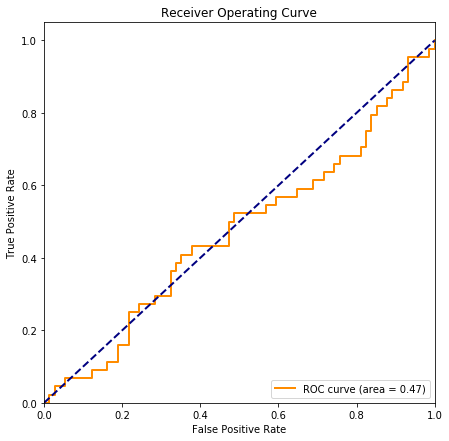

In [23]:
plot_roc_curve(test_data[0],predicted_labels_probs,False)